In [1]:
import pandas as pd
from zipfile import ZipFile
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

# Обработка данных

In [2]:
zip_path = "data/state_crashes.zip"
csv_filename = "car_crashes.csv"

with ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open(csv_filename) as csv_file:
        df = pd.read_csv(csv_file)

print(df.head())
print(df.info())
print(df.describe())

   Unnamed: 0  total  speeding  alcohol  not_distracted  no_previous  \
0           0   18.8     7.332    5.640          18.048       15.040   
1           1   18.1     7.421    4.525          16.290       17.014   
2           2   18.6     6.510    5.208          15.624       17.856   
3           3   22.4     4.032    5.824          21.056       21.280   
4           4   12.0     4.200    3.360          10.920       10.680   

   ins_premium  ins_losses abbrev  
0       784.55      145.08     AL  
1      1053.48      133.93     AK  
2       899.47      110.35     AZ  
3       827.34      142.39     AR  
4       878.41      165.63     CA  
<class 'pandas.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      51 non-null     int64  
 1   total           51 non-null     float64
 2   speeding        51 non-null     float64
 3   alcohol         51 non-null   

Предобработка

In [6]:
# Выбираем численные признаки для кластеризации
features = ['total', 'speeding', 'alcohol', 'not_distracted', 'no_previous', 'ins_premium', 'ins_losses']
X = df[features]

# Проверка на пропуски
print(X.isnull().sum())

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("№ Data")
for i, row in enumerate(X_scaled):
    print(i, row)

total             0
speeding          0
alcohol           0
not_distracted    0
no_previous       0
ins_premium       0
ins_losses        0
dtype: int64
№ Data
0 [ 0.73744574  1.1681476   0.43993758  1.00230055  0.27769155 -0.58008306
  0.4305138 ]
1 [ 0.56593556  1.2126951  -0.21131068  0.60853209  0.80725756  0.94325764
 -0.02289992]
2 [ 0.68844283  0.75670887  0.18761539  0.45935701  1.03314134  0.0708756
 -0.98177845]
3 [ 1.61949811 -0.48361373  0.54740815  1.67605228  1.95169961 -0.33770122
  0.32112519]
4 [-0.92865317 -0.39952407 -0.8917629  -0.594276   -0.89196792 -0.04841772
  1.26617765]
5 [-0.5366299   0.01692    -0.63009543 -0.63369765 -0.29104195 -0.2914793
  0.22027622]
6 [-1.22267063 -0.01511416 -0.5833691  -0.9356316  -1.38129335  1.02964051
  1.32270187]
7 [ 0.10040792  0.57951992 -0.01564416  0.1166575   0.54542553  1.42128062
  0.6907692 ]
8 [-2.42324191 -1.49769509 -1.92383077 -1.71868879 -2.17430102  2.19175919
  0.06330968]
9 [ 0.51693265 -0.62025945  0.17768604  0

# Подбор числа кластеров K means

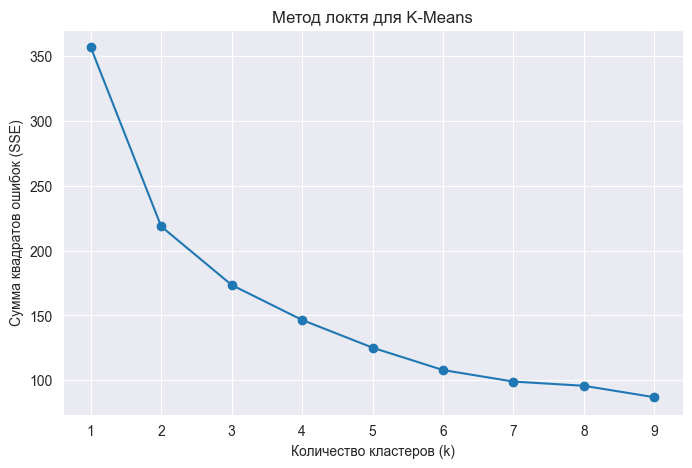

In [4]:
# Диапазон числа кластеров для проверки
cluster_range = range(1, 10)

sse = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # inertia_ — это сумма квадратов расстояний до центров

# Строим график "локтя"
plt.figure(figsize=(8,5))
plt.plot(cluster_range, sse, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов ошибок (SSE)')
plt.title('Метод локтя для K-Means')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

По графику локтя выбираем число кластеров 5

# Подбор числа кластеров Gaussian Mixture Model

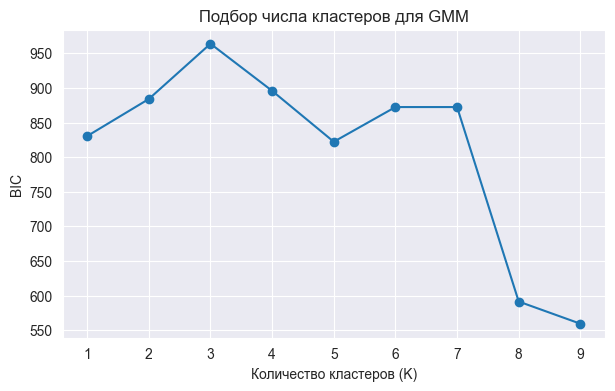

In [5]:
bic_values = []
cluster_range_gmm = range(1, 10)

for k in cluster_range_gmm:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    bic_values.append(gmm.bic(X_scaled))

# Визуализация BIC
plt.figure(figsize=(7,4))
plt.plot(cluster_range_gmm, bic_values, marker='o')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('BIC')
plt.title('Подбор числа кластеров для GMM')
plt.grid(True)
plt.show()

По графику выбираем число кластеров 8

# Кластеризация

In [6]:
k_opt = 5
k_gmm_opt = 8

# K-Means
kmeans_opt = KMeans(n_clusters=k_opt, random_state=42).fit(X_scaled)
kmeans_other = KMeans(n_clusters=k_gmm_opt, random_state=42).fit(X_scaled)

df['kmeans_opt'] = kmeans_opt.labels_
df['kmeans_gmm_k'] = kmeans_other.labels_

# GMM
gmm_opt = GaussianMixture(n_components=k_gmm_opt, random_state=42).fit(X_scaled)
gmm_other = GaussianMixture(n_components=k_opt, random_state=42).fit(X_scaled)

df['gmm_opt'] = gmm_opt.predict(X_scaled)
df['gmm_kmeans_k'] = gmm_other.predict(X_scaled)

# Метрики качества

In [7]:
def evaluate_clusters(X, labels, name):
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    print(f"{name}: Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}")

print("\n--- Внутренние метрики ---")
evaluate_clusters(X_scaled, df['kmeans_opt'], f"K-Means {k_opt} кластеров")
evaluate_clusters(X_scaled, df['kmeans_gmm_k'], f"K-Means {k_gmm_opt} кластеров")
evaluate_clusters(X_scaled, df['gmm_kmeans_k'], f"GMM {k_opt} кластеров")
evaluate_clusters(X_scaled, df['gmm_opt'], f"GMM {k_gmm_opt} кластеров")


--- Внутренние метрики ---
K-Means 5 кластеров: Silhouette=0.240, Davies-Bouldin=1.205
K-Means 8 кластеров: Silhouette=0.200, Davies-Bouldin=1.208
GMM 5 кластеров: Silhouette=0.243, Davies-Bouldin=1.187
GMM 8 кластеров: Silhouette=0.200, Davies-Bouldin=1.208


# Визуализация кластеров

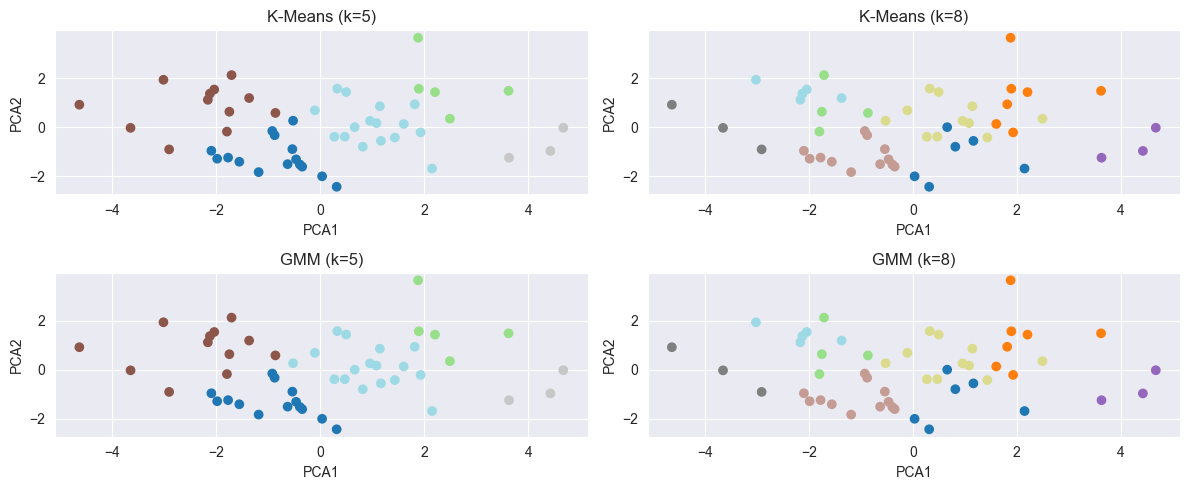

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['kmeans_opt'], cmap='tab20')
plt.title(f"K-Means (k={k_opt})")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.subplot(2,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['kmeans_gmm_k'], cmap='tab20')
plt.title(f"K-Means (k={k_gmm_opt})")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.subplot(2,2,3)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['gmm_kmeans_k'], cmap='tab20')
plt.title(f"GMM (k={k_opt})")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.subplot(2,2,4)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['gmm_opt'], cmap='tab20')
plt.title(f"GMM (k={k_gmm_opt})")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.tight_layout()
plt.show()

# Анализ полученных кластеров

Средние значения признаков

In [9]:
# Средние значения признаков по кластерам K-Means
kmeans_stats = (
    df
    .groupby('kmeans_opt')[features]
    .mean()
    .round(2)
)

print("K-Means — средние значения признаков по кластерам")
print(kmeans_stats)

K-Means — средние значения признаков по кластерам
            total  speeding  alcohol  not_distracted  no_previous  \
kmeans_opt                                                          
0           13.69      4.18     3.99           11.75        12.36   
1           21.20      6.69     6.48           19.01        19.53   
2           11.50      3.12     3.52            8.96         9.98   
3           23.07      7.64     9.75           21.53        19.37   
4           17.92      6.15     5.34           15.55        15.83   

            ins_premium  ins_losses  
kmeans_opt                           
0                752.15      115.67  
1                997.55      165.08  
2               1043.21      154.21  
3                787.98      103.72  
4                880.14      133.56  


In [10]:
# Средние значения признаков по кластерам GMM
gmm_stats = (
    df
    .groupby('gmm_opt')[features]
    .mean()
    .round(2)
)

print("\nGMM — средние значения признаков по кластерам")
print(gmm_stats)


GMM — средние значения признаков по кластерам
         total  speeding  alcohol  not_distracted  no_previous  ins_premium  \
gmm_opt                                                                       
0        16.68      6.34     5.27           14.98        14.53       710.48   
1        19.73      7.90     6.43           17.70        17.52       958.88   
2        13.70      3.38     4.06            8.15        12.96       898.05   
3        23.07      7.64     9.75           21.53        19.37       787.98   
4        13.28      4.04     3.92           11.28        11.94       755.44   
5         7.90      2.03     2.42            7.16         6.97      1020.74   
6        18.24      4.79     4.91           15.55        16.66       937.46   
7        11.90      3.57     3.75           10.69         9.41      1172.83   

         ins_losses  
gmm_opt              
0            111.75  
1            157.56  
2            166.96  
3            103.72  
4            117.74  
5       

Штаты, входящие в состав кластеров

In [11]:
print("\nШтаты по кластерам (K-Means):")
for cluster in sorted(df['kmeans_opt'].unique()):
    states = df[df['kmeans_opt'] == cluster]['abbrev'].tolist()
    print(f"Кластер {cluster} ({len(states)} штатов):")
    print(", ".join(states))


Штаты по кластерам (K-Means):
Кластер 0 (15 штатов):
CO, GA, ID, IL, IN, IA, ME, NE, NH, OH, OR, UT, VT, WA, WI
Кластер 1 (5 штатов):
AR, LA, OK, TX, WV
Кластер 2 (12 штатов):
CA, CT, DC, MD, MA, MI, MN, MS, NJ, NY, RI, VA
Кластер 3 (3 штатов):
MT, ND, SC
Кластер 4 (16 штатов):
AL, AK, AZ, DE, FL, HI, KS, KY, MO, NV, NM, NC, PA, SD, TN, WY


In [12]:
print("\nШтаты по кластерам (GMM):")
for cluster in sorted(df['gmm_opt'].unique()):
    states = df[df['gmm_opt'] == cluster]['abbrev'].tolist()
    print(f"Кластер {cluster} ({len(states)} штатов):")
    print(", ".join(states))


Штаты по кластерам (GMM):
Кластер 0 (6 штатов):
ID, ME, MO, NC, SD, WY
Кластер 1 (7 штатов):
AL, HI, LA, OK, PA, TX, WV
Кластер 2 (4 штатов):
CA, MD, MS, VA
Кластер 3 (3 штатов):
MT, ND, SC
Кластер 4 (12 штатов):
CO, IL, IN, IA, NE, NH, OH, OR, UT, VT, WA, WI
Кластер 5 (3 штатов):
DC, MA, MN
Кластер 6 (11 штатов):
AK, AZ, AR, DE, FL, GA, KS, KY, NV, NM, TN
Кластер 7 (5 штатов):
CT, MI, NJ, NY, RI


# Кластеризация данных из первой работы

Загрузка данных (ячейка из первой работы)

In [18]:
def merge_chunks_full_tracks(zip_path, max_interaction_chunks=20):
    with ZipFile(zip_path, 'r') as zip_file:
        tracks_stream = zip_file.open('zvuk-track_artist_embedding.parquet')
        df_tracks_full = pq.read_pandas(tracks_stream).to_pandas()
        print(f"Полная tracks таблица: {df_tracks_full.shape}")

    # Фильтруем tracks
    df_tracks = df_tracks_full[['track_id', 'artist_id', 'cluster_id']].drop_duplicates()

    # 2. читаем interactions ПО чанкам и сразу сливаем с tracks
    all_merged_chunks = []

    with ZipFile(zip_path, 'r') as zip_file:
        interactions_file = pq.ParquetFile(zip_file.open('zvuk-interactions.parquet'))
        print(f"Всего row groups: {interactions_file.num_row_groups}")

        for i in range(min(max_interaction_chunks, interactions_file.num_row_groups)):
            # Читаем чанк
            chunk = interactions_file.read_row_group(i).to_pandas()

            # Берем только нужные колонки
            chunk_txn = chunk[['user_id', 'track_id', 'session_id', 'datetime', 'play_duration']]

            merged_chunk = chunk_txn.merge(
                df_tracks,
                on='track_id',
                how='left'
            )

            all_merged_chunks.append(merged_chunk)
            print(f"Чанк {i+1}: {chunk.shape[0]} → {merged_chunk.shape[0]} строк")

    # 3. Собираем все чанки
    df_merged_full = pd.concat(all_merged_chunks, ignore_index=True)

    # 4. dropna только в конце на итоговом наборе
    before_dropna = len(df_merged_full)
    df_clean = df_merged_full.dropna(subset=['artist_id', 'cluster_id'])
    print(f"\nПосле dropna: {before_dropna:,} → {len(df_clean):,} строк ({100*(1-len(df_clean)/before_dropna):.1f}% удалено)")

    return df_clean

df_merged = merge_chunks_full_tracks('D:/дз/пис/IntelliganceSystems/assosiation/data/archive.zip', max_interaction_chunks=50)
print(f"Финальный размер: {df_merged.shape}")

# Очистка датасета: только ключевые колонки
key_columns = ['user_id', 'track_id', 'artist_id', 'cluster_id']
df_merged = df_merged[key_columns]

Полная tracks таблица: (2199876, 4)
Всего row groups: 933
Чанк 1: 262243 → 371024 строк
Чанк 2: 262243 → 372075 строк
Чанк 3: 262243 → 369357 строк
Чанк 4: 262243 → 370706 строк
Чанк 5: 262243 → 369224 строк
Чанк 6: 262243 → 371542 строк
Чанк 7: 262243 → 370001 строк
Чанк 8: 262243 → 369124 строк
Чанк 9: 262243 → 372090 строк
Чанк 10: 262243 → 371558 строк
Чанк 11: 262243 → 373336 строк
Чанк 12: 262243 → 370313 строк
Чанк 13: 262243 → 371585 строк
Чанк 14: 262243 → 371341 строк
Чанк 15: 262243 → 369705 строк
Чанк 16: 262243 → 373468 строк
Чанк 17: 262243 → 369405 строк
Чанк 18: 262243 → 370396 строк
Чанк 19: 262243 → 371476 строк
Чанк 20: 262243 → 372044 строк
Чанк 21: 262243 → 370684 строк
Чанк 22: 262243 → 371682 строк
Чанк 23: 262243 → 370939 строк
Чанк 24: 262243 → 370163 строк
Чанк 25: 262243 → 370188 строк
Чанк 26: 262243 → 370050 строк
Чанк 27: 262243 → 369625 строк
Чанк 28: 262243 → 370537 строк
Чанк 29: 262243 → 369343 строк
Чанк 30: 262243 → 369635 строк
Чанк 31: 262243 → 371

кластеризация

In [19]:
user_cluster_matrix = (
    df_merged
    .groupby(['user_id', 'cluster_id'])
    .size()
    .unstack(fill_value=0)
)

# нормализация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_cluster_matrix)

# Kmeans кластеризация
kmeans = KMeans(
    n_clusters=5,
    random_state=42,
    n_init=10
)

kmeans_labels = kmeans.fit_predict(X_scaled)
user_cluster_matrix['kmeans_cluster'] = kmeans_labels

# GMM кластеризация
gmm = GaussianMixture(
    n_components=5,
    random_state=42,
    covariance_type='full'
)

gmm_labels = gmm.fit_predict(X_scaled)

user_cluster_matrix['gmm_cluster'] = gmm_labels

kmeans_profile = (
    user_cluster_matrix
    .groupby('kmeans_cluster')
    .mean()
)

print(kmeans_profile)

gmm_profile = (
    user_cluster_matrix
    .groupby('gmm_cluster')
    .mean()
)

print(gmm_profile)

cluster_id             0         1         2         3         4         5  \
kmeans_cluster                                                               
0               0.663880  4.289894  3.210720  4.176543  4.086059  7.684288   
1               0.043524  0.856631  0.165408  0.227255  0.537816  1.128748   
2               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3               0.249498  6.024640  0.604672  0.886202  5.716372  7.509765   
4               0.000000  2.000000  0.000000  0.000000  3.000000  4.000000   

cluster_id               6           7         8         9  ...         119  \
kmeans_cluster                                              ...               
0                 4.259897    2.669535  2.221047  4.137940  ...    0.697566   
1                 0.727239    0.156581  0.144962  0.143190  ...    0.057258   
2               522.000000    0.000000  0.000000  0.000000  ...    0.000000   
3                 7.461398    0.398430  0.373700  0.129768